### Ferdinand Beaman's Renovation Project <br>
Part time<br>
Scheduled project review date/time: Jul 14, 2023, 1:15pm <br>
Instructor: Mark Barbour<br>
Blog post URL: https://ferdinandbeaman.blogspot.com/2023/07/hitting-my-stride.html


For this project, I am going through a database of homes sold in Kings County, Seattle. Ultimately, my goal is to assessing the features that affect the value of these properties in an attempt to advise a hypothetical renovation company what services they should offer to best increase the value of a home. <br>

Primarily, the statistical conclusions that will be drawn here will derive from OLS regressions. OLS regressions can competently handle multiple variables at once, estimate how much each independent variable contributes to the dependent variable, and also estimate how much of the variability seen in the dependent variable can seemingly be explained by the independent variables fed into it.

# Prepping the Data

As could be expected, I'll start by importing the libraries I foresee myself using and the data.

In [177]:
import pandas as pd
import numpy as np
from scipy import stats
import math
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('darkgrid')
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [178]:
base_df = pd.read_csv("data/kc_house_data.csv") #The Kings County data
base_df.drop(["view", "date", "sqft_above", "sqft_basement",
              "yr_renovated", "address","lat", "long"],
             axis = 1, inplace = True)#Drop columns I was advised to ignore

In [179]:
base_df

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,condition,grade,heat_source,sewer_system,sqft_garage,sqft_patio,yr_built
0,7399300360,675000.0,4,1.0,1180,7140,1.0,NO,NO,NO,Good,7 Average,Gas,PUBLIC,0,40,1969
1,8910500230,920000.0,5,2.5,2770,6703,1.0,NO,NO,YES,Average,7 Average,Oil,PUBLIC,0,240,1950
2,1180000275,311000.0,6,2.0,2880,6156,1.0,NO,NO,NO,Average,7 Average,Gas,PUBLIC,0,0,1956
3,1604601802,775000.0,3,3.0,2160,1400,2.0,NO,NO,NO,Average,9 Better,Gas,PUBLIC,200,270,2010
4,8562780790,592500.0,2,2.0,1120,758,2.0,NO,NO,YES,Average,7 Average,Electricity,PUBLIC,550,30,2012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30150,7834800180,1555000.0,5,2.0,1910,4000,1.5,NO,NO,NO,Good,8 Good,Oil,PUBLIC,0,210,1921
30151,194000695,1313000.0,3,2.0,2020,5800,2.0,NO,NO,NO,Average,7 Average,Gas,PUBLIC,0,520,2011
30152,7960100080,800000.0,3,2.0,1620,3600,1.0,NO,NO,YES,Average,7 Average,Gas,PUBLIC,240,110,1995
30153,2781280080,775000.0,3,2.5,2570,2889,2.0,NO,NO,NO,Average,8 Good,Gas,PUBLIC,480,100,2006


A little over 30 thousand homes. This should hopefully be more than enough to draw some useful conclusions.

## Exploration Phase

Firstly, I want to identify and assessing the types of data that's here<br>
Some categorical data may be able to be rewritten as integers, others may need to be one-hot encoded so statistics can be run on them.

In [180]:
base_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30155 entries, 0 to 30154
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            30155 non-null  int64  
 1   price         30155 non-null  float64
 2   bedrooms      30155 non-null  int64  
 3   bathrooms     30155 non-null  float64
 4   sqft_living   30155 non-null  int64  
 5   sqft_lot      30155 non-null  int64  
 6   floors        30155 non-null  float64
 7   waterfront    30155 non-null  object 
 8   greenbelt     30155 non-null  object 
 9   nuisance      30155 non-null  object 
 10  condition     30155 non-null  object 
 11  grade         30155 non-null  object 
 12  heat_source   30123 non-null  object 
 13  sewer_system  30141 non-null  object 
 14  sqft_garage   30155 non-null  int64  
 15  sqft_patio    30155 non-null  int64  
 16  yr_built      30155 non-null  int64  
dtypes: float64(3), int64(7), object(7)
memory usage: 3.9+ MB


Almost all of the categories are equally represented here. By eye, it seems like there are only a couple dozen missing values (which compared to the whole sample, are near-negligible to lose).

Also, about half of the variables are ostensibly categorical. Below, I'll see what to do with each of them.

In [181]:
base_df.heat_source.value_counts()

Gas                  20583
Electricity           6465
Oil                   2899
Gas/Solar               93
Electricity/Solar       59
Other                   20
Oil/Solar                4
Name: heat_source, dtype: int64

These are distinct categories that don't exist on a clear gradient. So these will be one-hot encoded.

In [182]:
base_df.grade.value_counts()

7 Average        11697
8 Good            9410
9 Better          3806
6 Low Average     2858
10 Very Good      1371
11 Excellent       406
5 Fair             393
12 Luxury          122
4 Low               51
13 Mansion          24
3 Poor              13
1 Cabin              2
2 Substandard        2
Name: grade, dtype: int64

"Grade" exists on a scale, so I'll remove the string portion and just use the integers.

In [183]:
base_df.condition.value_counts()

Average      18547
Good          8054
Very Good     3259
Fair           230
Poor            65
Name: condition, dtype: int64

Referencing the Kings County website (https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r#c) I can confidently change these to numerical values as well.

In [184]:
base_df.sewer_system.value_counts()

PUBLIC                25777
PRIVATE                4355
PRIVATE RESTRICTED        6
PUBLIC RESTRICTED         3
Name: sewer_system, dtype: int64

Another candidate for one-hot encoding. The "RESTRICTED" ones are probably not statistically useful, though, since there are only 9 of them together.

## Cleaning the data

Here I will follow through with the transformations I outlined above. This will involve changing grade and condition strings to numbers, changing the YES/NO variables such as "greenbelt" to 1s and 0s, remove the NaNs, one-hot encode the sewer system and heat source, and define a boundary for outliers to remove.

In [185]:
# Changing "grade" to a number
base_df.grade = pd.to_numeric(base_df.grade.str.slice(stop=2))

In [186]:
base_df.grade.value_counts()

7     11697
8      9410
9      3806
6      2858
10     1371
11      406
5       393
12      122
4        51
13       24
3        13
2         2
1         2
Name: grade, dtype: int64

In [187]:
# Changing "condition" to a number
condition_dict = {"Poor":0, "Fair":1, "Average":2, "Good":3, "Very Good": 4}
base_df.replace({"condition":condition_dict}, inplace = True)

In [188]:
# Changing the three yes/no categories into 1/0 
binary_dict = {"YES":1, "NO":0}
base_df.replace({"nuisance":binary_dict}, inplace = True)
base_df.replace({"greenbelt":binary_dict}, inplace = True)
base_df.replace({"waterfront":binary_dict}, inplace = True)
base_df

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,condition,grade,heat_source,sewer_system,sqft_garage,sqft_patio,yr_built
0,7399300360,675000.0,4,1.0,1180,7140,1.0,0,0,0,3,7,Gas,PUBLIC,0,40,1969
1,8910500230,920000.0,5,2.5,2770,6703,1.0,0,0,1,2,7,Oil,PUBLIC,0,240,1950
2,1180000275,311000.0,6,2.0,2880,6156,1.0,0,0,0,2,7,Gas,PUBLIC,0,0,1956
3,1604601802,775000.0,3,3.0,2160,1400,2.0,0,0,0,2,9,Gas,PUBLIC,200,270,2010
4,8562780790,592500.0,2,2.0,1120,758,2.0,0,0,1,2,7,Electricity,PUBLIC,550,30,2012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30150,7834800180,1555000.0,5,2.0,1910,4000,1.5,0,0,0,3,8,Oil,PUBLIC,0,210,1921
30151,194000695,1313000.0,3,2.0,2020,5800,2.0,0,0,0,2,7,Gas,PUBLIC,0,520,2011
30152,7960100080,800000.0,3,2.0,1620,3600,1.0,0,0,1,2,7,Gas,PUBLIC,240,110,1995
30153,2781280080,775000.0,3,2.5,2570,2889,2.0,0,0,0,2,8,Gas,PUBLIC,480,100,2006


In [189]:
#Identifying the rows with NaNs
nan_count = base_df.isna().sum()
nan_count

id               0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
greenbelt        0
nuisance         0
condition        0
grade            0
heat_source     32
sewer_system    14
sqft_garage      0
sqft_patio       0
yr_built         0
dtype: int64

In [190]:
#Deleting the rows with NaNs
base_df.dropna(axis=0, subset=["sewer_system", "heat_source"], inplace=True)

In [191]:
#One-hot encoding the categorical data columns
df = pd.get_dummies(base_df, columns=["heat_source", "sewer_system"], drop_first=True)
df.drop("id", axis = 1, inplace = True)
df.reset_index(inplace=True)

I am aware that there are multiple methods for identifying outliers, but naively I chose to use the method I am most comfortable with. This involves measuring the interquartile range (the distance between the 25th and 7th percentile), adding that value to the 75th percentile to establish an upper bound, subtracting the interquartile range from the 25th percentile to establish a lower bound, and removing all values outside of those boundaries.

In [192]:
# Finding the 25th and 75th percentiles
df.price.describe()

count    3.011100e+04
mean     1.108971e+06
std      8.965158e+05
min      2.736000e+04
25%      6.492360e+05
50%      8.600000e+05
75%      1.300000e+06
max      3.075000e+07
Name: price, dtype: float64

In [193]:
#Measuring the interquartile range.
1300000 - 649236

650764

Oddly enough, if I took the above number (about 651 thousand dollars) and subtracted it from the 25th percentile (about 650 thousand dollars), it would set the lower bound to be a slightly negative number. That is to say, there is no need to actually set a lower bound.

In [194]:
upper = 1300000 + (1300000 - 649236) # Calculating the upper bound

df = df[df["price"] < upper].copy() # Removing all the homes sold for more
                                    # than the upper number.
df

,index,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,...,yr_built,heat_source_Electricity/Solar,heat_source_Gas,heat_source_Gas/Solar,heat_source_Oil,heat_source_Oil/Solar,heat_source_Other,sewer_system_PRIVATE RESTRICTED,sewer_system_PUBLIC,sewer_system_PUBLIC RESTRICTED
0,0,675000.0,4,1.0,1180,7140,1.0,0,0,0,...,1969,0,1,0,0,0,0,0,1,0
1,1,920000.0,5,2.5,2770,6703,1.0,0,0,1,...,1950,0,0,0,1,0,0,0,1,0
2,2,311000.0,6,2.0,2880,6156,1.0,0,0,0,...,1956,0,1,0,0,0,0,0,1,0
3,3,775000.0,3,3.0,2160,1400,2.0,0,0,0,...,2010,0,1,0,0,0,0,0,1,0
4,4,592500.0,2,2.0,1120,758,2.0,0,0,1,...,2012,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30106,30150,1555000.0,5,2.0,1910,4000,1.5,0,0,0,...,1921,0,0,0,1,0,0,0,1,0
30107,30151,1313000.0,3,2.0,2020,5800,2.0,0,0,0,...,2011,0,1,0,0,0,0,0,1,0
30108,30152,800000.0,3,2.0,1620,3600,1.0,0,0,1,...,1995,0,1,0,0,0,0,0,1,0
30109,30153,775000.0,3,2.5,2570,2889,2.0,0,0,0,...,2006,0,1,0,0,0,0,0,1,0


Down to 27 thousand homes. What fraction of my data is left?

In [195]:
len(df)/len(base_df)

0.9040549965129022

90.4%, I lost a little more than I expected.

## Visualizing the basics

I just want to get a look at the way some of the more intuitive categories are. Just to set my expectations.

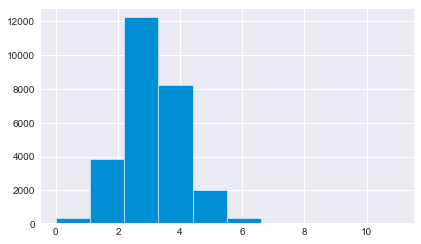

In [196]:
#Bedrooms
plt.hist(df.bedrooms);

There are homes with about 10 bedrooms in them? I don't assume these are single family homes, but I can't tell from here.

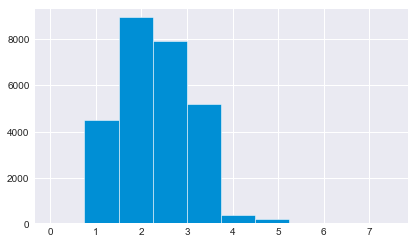

In [197]:
#Bathrooms
plt.hist(df.bathrooms);

Even though its bar is too small to be visualized, this is saying that there's at least one home with zero bathrooms. This home is now a strong personal curiosity of mine.

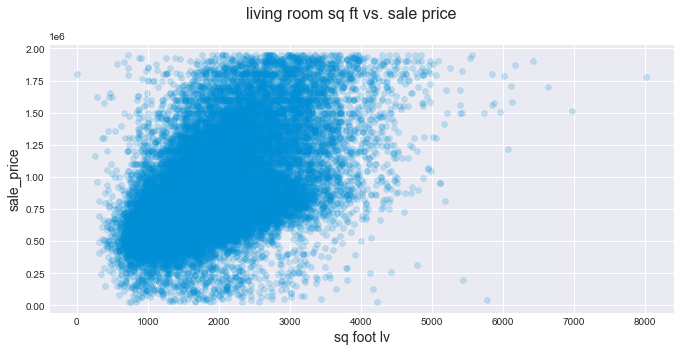

In [198]:
#Living room vs Sale Price
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('living room sq ft vs. sale price', fontsize=16)
ax.scatter(df.sqft_living, df.price, alpha = .2)
ax.set_xlabel('sq foot lv', fontsize=14)
ax.set_ylabel('sale_price', fontsize=14);

As expected, living room space seems to correlate with higher sale prices. However, the top of the scatterplot is cut off in a way that seems a bit premature.

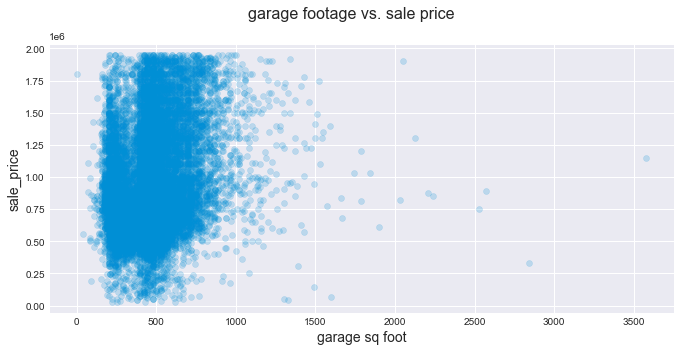

In [199]:
#Garage vs Sale Price
df_has_garage = df[df.sqft_garage > 0].copy()
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('garage footage vs. sale price', fontsize=16)
ax.scatter(df_has_garage.sqft_garage, df_has_garage.price, alpha = .2)
ax.set_xlabel('garage sq foot', fontsize=14)
ax.set_ylabel('sale_price', fontsize=14);

Similarly, the top of this scatterplot is also cut off sharply. I may need to recalculate what the outliers are.

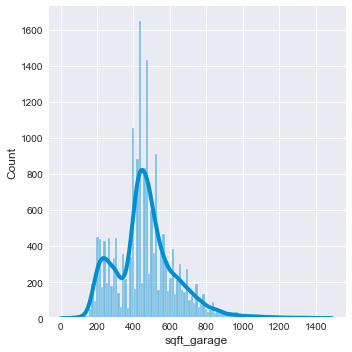

In [200]:
#Histogram of garages' square footage
sns.displot(df_has_garage[df_has_garage.sqft_garage<1500].sqft_garage, kde=True);

I don't know why, but garage square footage seems to be bimodal. 

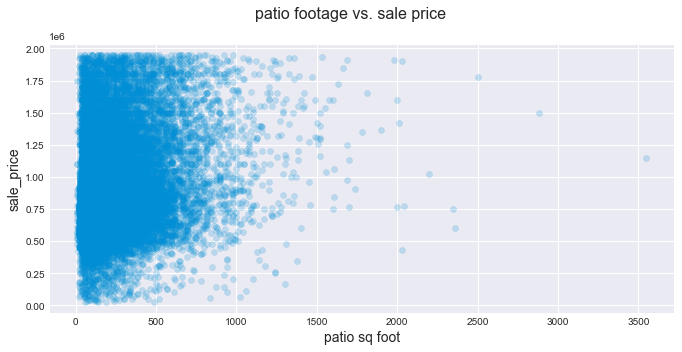

In [201]:
#Patio vs Sale Price
df_has_patio = df[df.sqft_patio>0].copy()
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('patio footage vs. sale price', fontsize=16)
ax.scatter(df_has_patio.sqft_patio, df_has_patio.price, alpha = .2)
ax.set_xlabel('patio sq foot', fontsize=14)
ax.set_ylabel('sale_price', fontsize=14);

Well, at this point I am convinced that the top of all of my scatterplots are telling me that I removed too many of my data points earlier. My expectation is that the "cloud" of points would have a much more diffuse edge. 

I lost about 10% of my data when I removed the outliers. So I will see if I retain more by switching my boundary to be two standard deviations away from the mean. If the data is close to normal, then I should only lose about 5% of my data that way.

In [202]:
#Finding the lower and upper bounds
print("new lower", base_df.price.mean()-(base_df.price.std()*2))
print("new upper", base_df.price.mean()+(base_df.price.std()*2))

new lower -684061.0086032962
new upper 2902002.311847958


Just like before, the new lower bound would be negative and is thus useless. But the new upper bound is quite a bit higher. About a million dollars, by the looks of it.

In [203]:
#Calculating the difference between my upper boundaries.
2902002.311847958 - upper #"upper" is my previous upper bound using IQR

951238.3118479578

That's nearly a million dollars, which given even what little I know about homes is a lot of money. So this is cause for optimism.

In [204]:
#Redoing the things I did after renaming base_df before removing outliers

df = pd.get_dummies(base_df, columns=["heat_source", 
                                      "sewer_system"], drop_first=True)
df.drop("id", axis = 1, inplace = True)
df.reset_index(inplace=True)

#Setting new upper bound
df = df[df["price"] < 2902002.31].copy()
df

,index,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,...,yr_built,heat_source_Electricity/Solar,heat_source_Gas,heat_source_Gas/Solar,heat_source_Oil,heat_source_Oil/Solar,heat_source_Other,sewer_system_PRIVATE RESTRICTED,sewer_system_PUBLIC,sewer_system_PUBLIC RESTRICTED
0,0,675000.0,4,1.0,1180,7140,1.0,0,0,0,...,1969,0,1,0,0,0,0,0,1,0
1,1,920000.0,5,2.5,2770,6703,1.0,0,0,1,...,1950,0,0,0,1,0,0,0,1,0
2,2,311000.0,6,2.0,2880,6156,1.0,0,0,0,...,1956,0,1,0,0,0,0,0,1,0
3,3,775000.0,3,3.0,2160,1400,2.0,0,0,0,...,2010,0,1,0,0,0,0,0,1,0
4,4,592500.0,2,2.0,1120,758,2.0,0,0,1,...,2012,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30106,30150,1555000.0,5,2.0,1910,4000,1.5,0,0,0,...,1921,0,0,0,1,0,0,0,1,0
30107,30151,1313000.0,3,2.0,2020,5800,2.0,0,0,0,...,2011,0,1,0,0,0,0,0,1,0
30108,30152,800000.0,3,2.0,1620,3600,1.0,0,0,1,...,1995,0,1,0,0,0,0,0,1,0
30109,30153,775000.0,3,2.5,2570,2889,2.0,0,0,0,...,2006,0,1,0,0,0,0,0,1,0


29 thousand homes is about 2 thousand higher than before. So what fraction of my data was removed this time?

In [205]:
#What fraction of my data do I have now?
len(df)/len(base_df)

0.9686161203546877

Only a little more than 3% of the data was lost this time, which gives me about another 5% or so than I had before. Now I'll revisit those charts from before to see if they look any better.

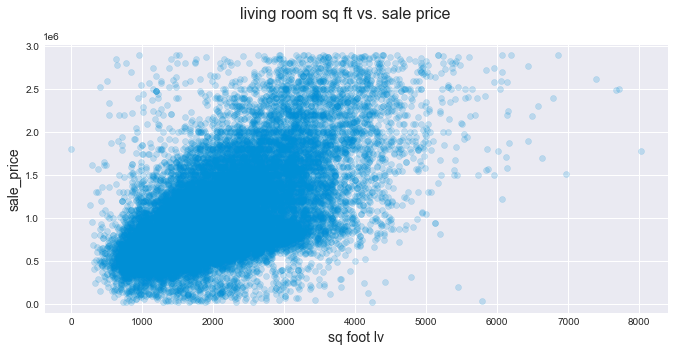

In [206]:
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('living room sq ft vs. sale price', fontsize=16)
ax.scatter(df.sqft_living, df.price, alpha = .2)
ax.set_xlabel('sq foot lv', fontsize=14)
ax.set_ylabel('sale_price', fontsize=14);

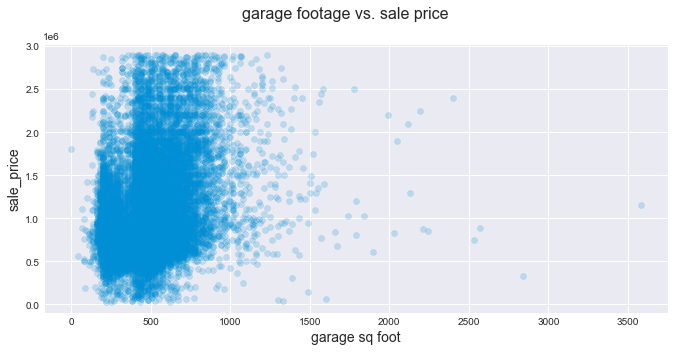

In [207]:
df_has_garage = df[df.sqft_garage > 0].copy() #df of houses with garages
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('garage footage vs. sale price', fontsize=16)
ax.scatter(df_has_garage.sqft_garage, df_has_garage.price, alpha = .2)
ax.set_xlabel('garage sq foot', fontsize=14)
ax.set_ylabel('sale_price', fontsize=14);

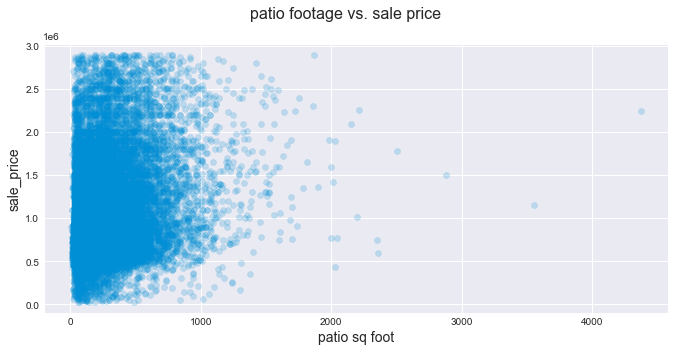

In [208]:
df_has_patio = df[df.sqft_patio>0].copy() #df of houses with patios
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('patio footage vs. sale price', fontsize=16)
ax.scatter(df_has_patio.sqft_patio, df_has_patio.price, alpha = .2)
ax.set_xlabel('patio sq foot', fontsize=14)
ax.set_ylabel('sale_price', fontsize=14);

This doesn't look perfect to me, but it is quite a bit better. The tops of each scatterplot are in fact a lot less densely packed than before. Especially for living room size. That might be partly because living room size is much more spread out on the horizontal axis, giving each point the appearance of more space and thus the whole graph looks "softer". But this will do for now.

I'll also include the existence of a patio/garage at all as their own columns

In [209]:
df.loc[df.sqft_garage > 0, "garage"] = 1
df.loc[df.sqft_garage == 0, "garage"] = 0

df.loc[df.sqft_patio > 0, "patio"] = 1
df.loc[df.sqft_patio == 0, "patio"] = 0

Okay, so now that everything is set up, let's see what features correlate significantly with price.

# Stats

### Basic OLS
We're just looking at each variable individually. The R squared value of the printouts say what percentage of the price is explained by the independent variable(s) we are testing.

In [210]:
features = "bedrooms bathrooms sqft_living patio garage condition grade".split()
y = df["price"]
for feat in features:
    X_baseline = df[[feat]]
    baseline_model = sm.OLS(y, sm.add_constant(X_baseline))
    baseline_results = baseline_model.fit()
    print(feat)
    print(baseline_results.summary())
    print("\n")
    print("\n")

#
X_baseline = df_has_garage[["sqft_garage"]]
y = df_has_garage["price"]
baseline_model = sm.OLS(y, sm.add_constant(X_baseline))
baseline_results = baseline_model.fit()
print("garage size")
print(baseline_results.summary())
print("\n")
print("\n")

y = df_has_patio["price"]
X_baseline = df_has_patio[["sqft_patio"]]
baseline_model = sm.OLS(y, sm.add_constant(X_baseline))
baseline_results = baseline_model.fit()
print("patio size")
print(baseline_results.summary())

bedrooms
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     3755.
Date:                Sun, 23 Jul 2023   Prob (F-statistic):               0.00
Time:                        22:25:14   Log-Likelihood:            -4.2361e+05
No. Observations:               29166   AIC:                         8.472e+05
Df Residuals:                   29164   BIC:                         8.472e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.792e+05   1.05e+04     36.024

The P values for each of these variables are all presented as zero, meaning that the chances that any of these aren't related to the sale price are vanishingly small.

The size of the living room seem to be the most closely tied to the price, as the variation in the living rooms seem to explain about 38% of the dependent variable.

Confusingly, condition is purported to explain 0.0% of the price, but it still has a nonzero coefficient and a zero P value. The printout seems to be suggesting that condition explains none of the price, but for every bump in condition corresponds to a bump in price for 16,000 dollars. Considering that this about 2% of the price of the median house (about 800k), I'm confused as to how it can be only explaining 0.0% of the price.

Every bathroom seems to be accounting for 300,000 dollar's worth of value, but they might be unweildy to add to a home. I will hold onto that if I need to.

Below, here is a visualization of each variable's rsquared value.

In [242]:
# Getting the list of each variable and their associated rsquared
variables = []
rsquareds = []
for x in all_x:
    model = sm.OLS(df["price"], 
                        sm.add_constant(df[x]))
    results = model.fit()
    variables.append(x)
    rsquareds.append(results.rsquared)


In [243]:
#Turning it into a dataframe, which is easy to sort and visualize
r2_df = pd.DataFrame()

r2_df["variables"] = variables
r2_df["rsquared"] = rsquareds

r2_df = r2_df.sort_values("rsquared")

In [244]:
r2_df

,variables,rsquared
6,nuisance,0.000376
15,sewer_system_PUBLIC,0.000423
7,condition,0.000480
13,heat_source_Gas/Solar,0.001846
4,waterfront,0.002907
14,heat_source_Oil,0.006343
3,sqft_lot,0.006487
11,yr_built,0.009132
5,greenbelt,0.013111
12,heat_source_Gas,0.034791


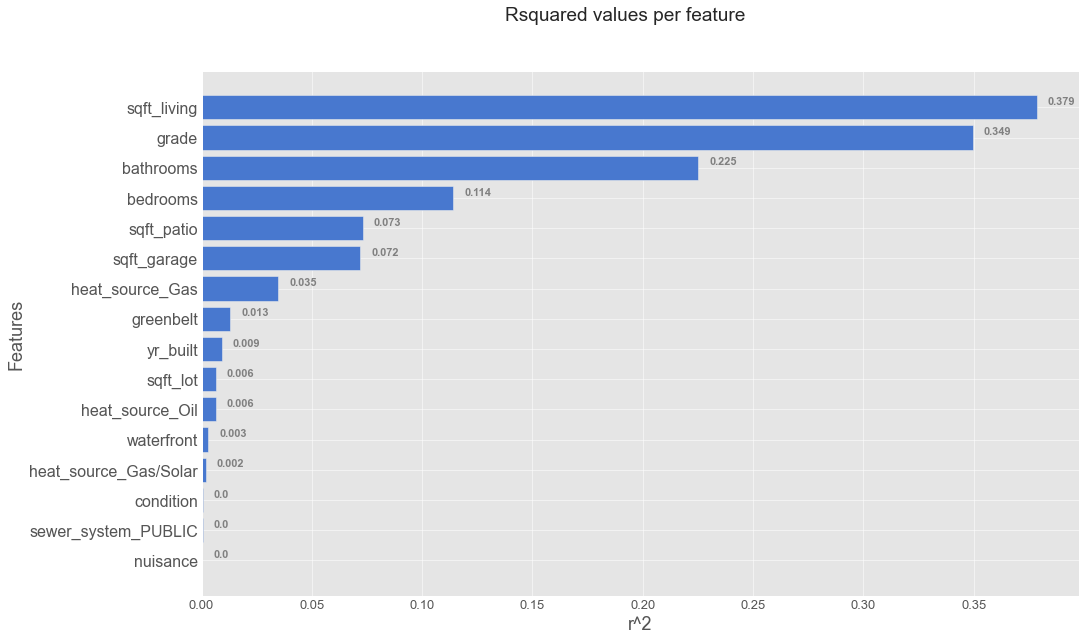

In [263]:
#Generating graph
plt.style.use("seaborn-muted")
fig, ax = plt.subplots(figsize =(14, 9))

plt.rcParams['font.size'] = 13

ax.set_yticklabels(r2_df["variables"],fontsize=16)

ax.barh(r2_df["variables"], r2_df["rsquared"])

#Citation: Template from https://www.geeksforgeeks.org/bar-plot-in-matplotlib/
for i in ax.patches:
    plt.text(i.get_width()+.005, i.get_y()+0.5,
             str(round((i.get_width()), 3)),
             fontsize = 11, fontweight ='bold',
             color ='grey')

fig.suptitle('Rsquared values per feature', fontsize=19, )
plt.xlabel('r^2', fontsize=18)
plt.ylabel('Features', fontsize=18)
plt.show()

### Log Transformations

We should check to see if any of the independent variables gain explanatory power when log transformed. Obviously this only works for numerical data, but some of these still need to be massaged in order to work.

You can't take the log of 0, so data that equals zero isn't useful to us. For the bathrooms and bedrooms, there are somehow homes without any. But they are rare. Since they are rare, we can remove them.

However, I decided to shift the condition scores up by 1 rather than delete them. Since the decision to have a 0 on the bottom of a scale is somewhat arbitrary, 
this is different to me compared to the rooms above. Rooms are real, tangible, countable things.

In [211]:
# You can't take the log of anything with 0 as a value, so this "log" df
# just removes them
df_log = df[df["bathrooms"] > 0].copy()
df_log = df_log[df_log["bedrooms"] > 0].copy()

df_log["condition"] = df_log["condition"] +1 
                                
# Running single variable OLS regression with log transformed values
features = "bedrooms bathrooms sqft_living condition grade".split()
y = df_log["price"]
for feat in features:
    X_baseline = np.log(df_log[[feat]])
    baseline_model = sm.OLS(y, sm.add_constant(X_baseline))
    baseline_results = baseline_model.fit()
    print("log ", feat)
    print(baseline_results.summary())
    print("\n")
    print("\n")

# I can use my preexisting dfs with nonzero garage space...  
X_baseline = np.log(df_has_garage[["sqft_garage"]])
y = df_has_garage["price"]
baseline_model = sm.OLS(y, sm.add_constant(X_baseline))
baseline_results = baseline_model.fit()
print("log garage size")
print(baseline_results.summary())
print("\n")
print("\n")

# ... and with nonzero patio space.
y = df_has_patio["price"]
X_baseline = np.log(df_has_patio[["sqft_patio"]])
baseline_model = sm.OLS(y, sm.add_constant(X_baseline))
baseline_results = baseline_model.fit()
print("log patio size")
print(baseline_results.summary())

log  bedrooms
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     3531.
Date:                Sun, 23 Jul 2023   Prob (F-statistic):               0.00
Time:                        22:25:14   Log-Likelihood:            -4.2309e+05
No. Observations:               29124   AIC:                         8.462e+05
Df Residuals:                   29122   BIC:                         8.462e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.241e+05   1.17e+04     2

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     1104.
Date:                Sun, 23 Jul 2023   Prob (F-statistic):          2.78e-236
Time:                        22:25:14   Log-Likelihood:            -3.2800e+05
No. Observations:               22487   AIC:                         6.560e+05
Df Residuals:                   22485   BIC:                         6.560e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.372e+05   2.18e+04     15.504      0.0

Conveniently for clarity in communication, none of the features were more accurately predictive when log transformed. Well, condition went from an rsquared of 0 to 0.001, so there's that.

## Multivariable OLS

Now OLS regressions will be run that take all of the variables into account at once.

In [212]:
# Establishing the names of the candidate variables.
df.columns

Index(['index', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'greenbelt', 'nuisance', 'condition', 'grade',
       'sqft_garage', 'sqft_patio', 'yr_built',
       'heat_source_Electricity/Solar', 'heat_source_Gas',
       'heat_source_Gas/Solar', 'heat_source_Oil', 'heat_source_Oil/Solar',
       'heat_source_Other', 'sewer_system_PRIVATE RESTRICTED',
       'sewer_system_PUBLIC', 'sewer_system_PUBLIC RESTRICTED', 'garage',
       'patio'],
      dtype='object')

In [213]:
# The independent variables
all_x = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'greenbelt', 'nuisance', 'condition', 'grade',
       'sqft_garage', 'sqft_patio', 'yr_built',
       'heat_source_Electricity/Solar', 'heat_source_Gas',
       'heat_source_Gas/Solar', 'heat_source_Oil', 'heat_source_Oil/Solar',
       'heat_source_Other', 'sewer_system_PRIVATE RESTRICTED',
       'sewer_system_PUBLIC', 'sewer_system_PUBLIC RESTRICTED']
y = df["price"]
all_model = sm.OLS(y, sm.add_constant(df[all_x]))
all_results = all_model.fit()
print(all_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.497
Model:                            OLS   Adj. R-squared:                  0.497
Method:                 Least Squares   F-statistic:                     1309.
Date:                Sun, 23 Jul 2023   Prob (F-statistic):               0.00
Time:                        22:25:14   Log-Likelihood:            -4.1535e+05
No. Observations:               29166   AIC:                         8.308e+05
Df Residuals:                   29143   BIC:                         8.309e+05
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

#### Our new adjusted R squared is 49.7%, meaning that almost half of the value of a house can be explained by the model.

Bathrooms lost a lot of perceived value when everything was taken together. We're down to about 49,000 dollars per bathroom.

There were a few features that had P values that are too large to confidently claim that they are affecting the price. Those features were predominantly ones with very small samples. Either way, let's recalculate the model without them.

In [214]:
all_x = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 
         'waterfront', 'greenbelt', 'nuisance', 'condition', 'grade',
       'sqft_garage', 'sqft_patio', 'yr_built', 'heat_source_Gas',
       'heat_source_Gas/Solar', 'heat_source_Oil', 'sewer_system_PUBLIC']
y = df["price"]
all_model = sm.OLS(y, sm.add_constant(df[all_x]))
all_results = all_model.fit()
print(all_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.497
Model:                            OLS   Adj. R-squared:                  0.497
Method:                 Least Squares   F-statistic:                     1798.
Date:                Sun, 23 Jul 2023   Prob (F-statistic):               0.00
Time:                        22:25:14   Log-Likelihood:            -4.1536e+05
No. Observations:               29166   AIC:                         8.308e+05
Df Residuals:                   29149   BIC:                         8.309e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  6.556e+

I didn't lose any explanatory power with this approach.

#### The model is explaining 42.2% of the variability for price.

# Testing Assumptions for Linear Regression

Linear regression analysis assumes several things are true about the data. Those things are: a lack of multicollinearity (independence of the variables), linearity, and both homoschedasticity and normality in the residuals. 

### Multicollinearity

I can test for multicollinearity quite easily by seeing if the correlation coefficients between independent variables are too high. Flatiron gave me an initial estimate to use of .7 to use as my lower bound.

In [267]:
data_pred = df[all_x]
data_pred.corr().abs() >= .7

,bedrooms,bathrooms,sqft_living,sqft_lot,waterfront,greenbelt,nuisance,condition,grade,sqft_garage,sqft_patio,yr_built,heat_source_Gas,heat_source_Gas/Solar,heat_source_Oil,sewer_system_PUBLIC
bedrooms,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
bathrooms,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False
sqft_living,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False
sqft_lot,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
waterfront,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
greenbelt,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
nuisance,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
condition,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False
grade,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
sqft_garage,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False


Bathrooms and sqft_living have strong correlations with one another, the rest do not.

Here is a little bit of a more pared down version with just the more apparently meaningful variables, this time with price added in:

In [279]:
data_pred = df[["price",'bedrooms', 'bathrooms', 'sqft_living', 
         'waterfront', 'greenbelt', 'condition', 'grade',
       'sqft_garage', 'sqft_patio', 'yr_built']]
data_pred.corr()["price"]

price          1.000000
bedrooms       0.337745
bathrooms      0.474533
sqft_living    0.615308
waterfront     0.053918
greenbelt      0.114501
condition      0.021909
grade          0.591160
sqft_garage    0.268340
sqft_patio     0.270138
yr_built       0.095560
Name: price, dtype: float64

In [274]:
#And here is that same chart, but with strong correlations explicitly labeled
#(defined as 0.7 or higher)
data_pred = df[["price",'bedrooms', 'bathrooms', 'sqft_living', 
         'waterfront', 'greenbelt', 'condition', 'grade',
       'sqft_garage', 'sqft_patio', 'yr_built']]
data_pred.corr().abs() >= 0.7

,price,bedrooms,bathrooms,sqft_living,waterfront,greenbelt,condition,grade,sqft_garage,sqft_patio,yr_built
price,True,False,False,False,False,False,False,False,False,False,False
bedrooms,False,True,False,False,False,False,False,False,False,False,False
bathrooms,False,False,True,True,False,False,False,False,False,False,False
sqft_living,False,False,True,True,False,False,False,False,False,False,False
waterfront,False,False,False,False,True,False,False,False,False,False,False
greenbelt,False,False,False,False,False,True,False,False,False,False,False
condition,False,False,False,False,False,False,True,False,False,False,False
grade,False,False,False,False,False,False,False,True,False,False,False
sqft_garage,False,False,False,False,False,False,False,False,True,False,False
sqft_patio,False,False,False,False,False,False,False,False,False,True,False


### Linearity

The linear rainbow test checks to see if the an independent variable follows roughly a linear relationship with respect to a dependent variable. If the result is smaller than 0.05, then we reject the null hypothesis that the data is linear.

In [216]:
from statsmodels.stats.diagnostic import linear_rainbow

feats = ["bedrooms", "bathrooms", "sqft_living","sqft_patio", "sqft_garage",
        "condition", "grade"]

for feat in feats:
    y = df["price"]
    X = df[[feat]]
    linear_model = sm.OLS(y, sm.add_constant(X))
    linear_results = linear_model.fit()
    print(feat)
    print(linear_rainbow(linear_results)[1])
    print("\n")

bedrooms
0.10071057383103876


bathrooms
0.13201488724335098


sqft_living
0.016513198247591288


sqft_patio
0.08918607076638364


sqft_garage
0.13425603555854584


condition
0.13997660908783063


grade
0.05923369847517214




Sqft_living ended up failing the linearity assumption. However, it didn't improve its predictive capabilities when I log-transformed it. I wonder if there are other transformations I will learn when I become a more mature analyst?

### Normality
The original regressions that I ran with individual variables all have Jarque-Bera tests in their printouts. The JB test is for the normality assumption. And every single one of the above features failed the JB test for normality.

I'll just look at a Quantile Quantile plot to see what's going on.

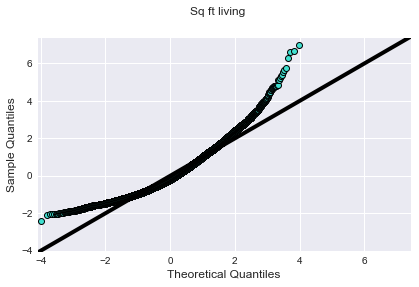

In [217]:
fig, ax = plt.subplots()
#I chose living room area since it was the most explanatory before.
sm.graphics.qqplot(df["sqft_living"], dist=stats.norm, line='45', fit=True,
                   ax=ax)

scatter = ax.lines[0]
line = ax.lines[1]
scatter.set_markeredgecolor("black")
scatter.set_markerfacecolor("turquoise")
line.set_color("black")
fig.suptitle("Sq ft living");

Hmmmmmm, this is troublesome. If nothing passes these tests, then my data is messier than I expected it to be. I'm not sure at what point we have strayed too far from perfect data before we need to find a new approach. But this is worrysome to me.

Maybe it's an issue with outliers on the variables? I'll test living room area with its own outliers removed.

In [218]:
2410-1370 #sqft_living IQR
no_outlier_lv = df[(df["sqft_living"] < 3450) & 
                   (df["sqft_living"] > 330)].copy()

In [219]:
from statsmodels.stats.stattools import jarque_bera
y = no_outlier_lv["price"]
X_baseline = no_outlier_lv[["sqft_living"]]
baseline_model = sm.OLS(y, sm.add_constant(X_baseline))
baseline_results = baseline_model.fit()
print("outlier-less living room JB test")
print(jarque_bera(baseline_results.resid)[1])

outlier-less living room JB test
0.0


Alright, so that's another failed JB test. So nothing has normally distributed residuals. I wonder what could cause that?

### Homoschedasticity

The het_goldfeldquandt test tells us if data satisfies this assumption. The second number on the printout is like the value we checked for the linear rainbow: if it's 0.05 or less, we need to reject the null hypothesis of homoschedastistic residuals.

In [220]:
from statsmodels.stats.diagnostic import het_goldfeldquandt

In [221]:
for feat in feats:
    y = df["price"]
    X = df[[feat]]
    linear_model = sm.OLS(y, sm.add_constant(X))
    linear_results = linear_model.fit()
    print(feat)
    print(het_goldfeldquandt(y, X, alternative='two-sided'))
    print("\n")

bedrooms
(0.9891743878554159, 0.5110655890462095, 'two-sided')


bathrooms
(0.9835483165441863, 0.31655708419922834, 'two-sided')


sqft_living
(0.9915652507406674, 0.6090545385444139, 'two-sided')


sqft_patio
(1.0004443777905307, 0.9785999418459354, 'two-sided')


sqft_garage
(0.982649503725694, 0.29062223820481975, 'two-sided')


condition
(0.9929829926538526, 0.6707211920921984, 'two-sided')


grade
(1.0011778215895546, 0.9433409173306966, 'two-sided')




"Grade" was close, but everything passed.
The "KS" test also checks for this, and I'll try it too.

In [222]:
import scipy
for feat in feats:
    print(feat, scipy.stats.kstest(df[feat], 
                    "norm", args = (np.mean(df[feat]), np.std(df[feat]))))

bedrooms KstestResult(statistic=0.2356441631250481, pvalue=0.0)
bathrooms KstestResult(statistic=0.15241724062347806, pvalue=0.0)
sqft_living KstestResult(statistic=0.07387380989963549, pvalue=7.248823650092233e-139)
sqft_patio KstestResult(statistic=0.18496369527764334, pvalue=0.0)
sqft_garage KstestResult(statistic=0.2129547483536784, pvalue=0.0)
condition KstestResult(statistic=0.3717056737731804, pvalue=0.0)
grade KstestResult(statistic=0.22085967101257403, pvalue=0.0)


Great. Everything passed a second time.

# Testing other transformations and subsets

## Higher order regressions

Some data is more accurately modeled not with linear regressions (first power regressions), but with higher order regressions. So I'll test them at this point. The printout will show the difference in explanatory power of the higher order regression against the original OLS.

In [223]:
#2nd power?
for feat in feats:
    df_quad = df.copy()
    df_quad[feat] = df_quad[feat]**2
    sq_results = sm.OLS(df_quad["price"], #The squared data's results
                             sm.add_constant(df_quad[feat])).fit()
    norm_results = sm.OLS(df["price"], #The original OLS to compare
                             sm.add_constant(df[feat])).fit()
    print(feat)
    print("change from original =", sq_results.rsquared-norm_results.rsquared)
    print("\n")

bedrooms
change from original = -0.010162156495328145


bathrooms
change from original = -0.0025538518203890304


sqft_living
change from original = -0.013876879498876948


sqft_patio
change from original = -0.039393405625060884


sqft_garage
change from original = -0.006099661346317009


condition
change from original = -6.416779921869509e-05


grade
change from original = 0.014659630970719428




Every score got worse.

In [224]:
#3rd power?
for feat in feats:
    df_third = df.copy()
    df_third[feat] = df_third[feat]**3
    norm_results = sm.OLS(df["price"], 
                             sm.add_constant(df[feat])).fit() 
    cbd_results = sm.OLS(df_third["price"], 
                         sm.add_constant(df_third[feat])).fit()
    print(feat)
    print("change=", cbd_results.rsquared - norm_results.rsquared)
    print("\n")

bedrooms
change= -0.03525135563589066


bathrooms
change= -0.04477990860548231


sqft_living
change= -0.08112668754173757


sqft_patio
change= -0.0667661592214972


sqft_garage
change= -0.05370167144523619


condition
change= -1.7818655756451918e-05


grade
change= 0.019314268527375167




That didn't improve anything in a meaningful way either. Since I tried both an even and an odd powered relationship, and neither alteration performed well, there is no good reason to try any higher powers.

## Slicing categorical values?

I'm going to see if things are more significant if we just have houses with certain binary features. Remember that my original Rsquared was .497

In [225]:
#New dfs for each feature.
waterfront_df = df[df["waterfront"]==1].copy()
greenbelt_df = df[df["greenbelt"]==1].copy()
nuisance_df = df[df["nuisance"]==1].copy()

In [226]:
#First, waterfront adjacent homes.
waterfront_model = sm.OLS(waterfront_df["price"], sm.add_constant(waterfront_df[all_x]))
waterfront_results = waterfront_model.fit()
print(waterfront_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.416
Model:                            OLS   Adj. R-squared:                  0.395
Method:                 Least Squares   F-statistic:                     19.20
Date:                Sun, 23 Jul 2023   Prob (F-statistic):           8.54e-34
Time:                        22:25:15   Log-Likelihood:                -5311.1
No. Observations:                 364   AIC:                         1.065e+04
Df Residuals:                     350   BIC:                         1.070e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
bedrooms              -3.616e+

Waterfront houses only have 41% of their variance explained by the features. This is probably because they have their prices better explained by location. Also, alarmingly, almost every feature suddenly has its p value over the .05 threshold, rendering the results unreliable.

In [227]:
#Next, greenbelt adjacent homes.
greenbelt_model = sm.OLS(greenbelt_df["price"], sm.add_constant(greenbelt_df[all_x]))
greenbelt_results = greenbelt_model.fit()
print(greenbelt_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.632
Model:                            OLS   Adj. R-squared:                  0.625
Method:                 Least Squares   F-statistic:                     88.40
Date:                Sun, 23 Jul 2023   Prob (F-statistic):          8.54e-146
Time:                        22:25:15   Log-Likelihood:                -10447.
No. Observations:                 735   AIC:                         2.092e+04
Df Residuals:                     720   BIC:                         2.099e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
bedrooms               -4.23e+

Wow
#### If we only look at properties on a greenbelt, we can explain 63 percent of the variability!
(That may be because there are not many greenbelt homes and they're somewhat similar.)

In [228]:
#Lastly, nuisance adjacent homes
nuisance_model = sm.OLS(nuisance_df["price"], sm.add_constant(nuisance_df[all_x]))
nuisance_results = nuisance_model.fit()
print(nuisance_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.482
Model:                            OLS   Adj. R-squared:                  0.480
Method:                 Least Squares   F-statistic:                     310.9
Date:                Sun, 23 Jul 2023   Prob (F-statistic):               0.00
Time:                        22:25:15   Log-Likelihood:                -71639.
No. Observations:                5032   AIC:                         1.433e+05
Df Residuals:                    5016   BIC:                         1.434e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
bedrooms              -2.879e+

The houses near a nuisance are about as explicable as the original sample.

# Condition and Grade

Building more rooms or living rooms will be impractical. Can we at least give a recommendation to increase the condition and/or grade of the place?

Let me just remind myself of what all the values are for these, especially since a few things might be a little different now.

In [229]:
df["condition"].value_counts(sort=False)

0       60
1      225
2    17828
3     7879
4     3174
Name: condition, dtype: int64

There are enough representatives for each layer of condition for us to run an analysis.

In [230]:
df["grade"].value_counts(sort=False)

2         1
3         9
4        45
5       381
6      2832
7     11654
8      9316
9      3626
10     1073
11      200
12       28
13        1
Name: grade, dtype: int64

The grade grades are almost normally distributed just visually. Surprisingly, there are no grades of 1 left in my sample.

### Condition

According to the website condition is related to things like "painted surfaces, roofing, plumbing, and heating".

The following code will find the mean and median cost of houses with particular condition scores, and then compare the mean and median at that level with the previous level.

In [231]:
prev_mean = 0
prev_med = 0
for i in range(5):
    idf = df[df["condition"] == i].copy()
    print(i)
    mean = idf.price.mean()
    med = idf.price.median()
    print((mean/1000).round(1), "= mean in k")
    print((med/1000).round(1), "= median in k")
    print("num of houses", len(idf))
    if i > 0:
        print("change in mean in thousands", ((mean-prev_mean)/1000).round(1))
        print("mean change in %", (((mean-prev_mean)/prev_mean)*100).round(1))
        print("change in median in thousands", ((med-prev_med)/1000).round(1))
        print("median change in %", (((med-prev_med)/prev_med)*100).round(1))
    else:
        pass
    prev_mean = mean
    prev_med = med
    print("\n")

0
596.5 = mean in k
565.0 = median in k
num of houses 60


1
792.5 = mean in k
662.0 = median in k
num of houses 225
change in mean in thousands 196.0
mean change in % 32.9
change in median in thousands 97.0
median change in % 17.2


2
1004.0 = mean in k
850.0 = median in k
num of houses 17828
change in mean in thousands 211.5
mean change in % 26.7
change in median in thousands 188.0
median change in % 28.4


3
980.2 = mean in k
850.0 = median in k
num of houses 7879
change in mean in thousands -23.8
mean change in % -2.4
change in median in thousands 0.0
median change in % 0.0


4
1045.7 = mean in k
890.0 = median in k
num of houses 3174
change in mean in thousands 65.5
mean change in % 6.7
change in median in thousands 40.0
median change in % 4.7




There seems to be a general trend upward at the beginning that peters out. Level 3 homes are just about as expensive as Level 2.

Let's see how powerfully condition explains the price of a home for the low scores.

In [232]:
low_cond_df = df[df["condition"]  < 3].copy() #Conditions less than 3
y = low_cond_df["price"]
all_model = sm.OLS(y, sm.add_constant(low_cond_df[all_x]))
all_results = all_model.fit()
print(all_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                     1101.
Date:                Sun, 23 Jul 2023   Prob (F-statistic):               0.00
Time:                        22:25:15   Log-Likelihood:            -2.5814e+05
No. Observations:               18113   AIC:                         5.163e+05
Df Residuals:                   18096   BIC:                         5.165e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  6.334e+

In [233]:
low_cond_df = df[df["condition"]  < 3].copy()
low_cond_model = sm.OLS(low_cond_df["price"], 
                        sm.add_constant(low_cond_df["condition"]))
low_cond_results = low_cond_model.fit()
print(low_cond_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     71.63
Date:                Sun, 23 Jul 2023   Prob (F-statistic):           2.80e-17
Time:                        22:25:15   Log-Likelihood:            -2.6427e+05
No. Observations:               18113   AIC:                         5.285e+05
Df Residuals:                   18111   BIC:                         5.286e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        5.89e+05   4.87e+04     12.089      0.0

Boo. There was a small uptick in explanatory power in the big model, but condition itself doesn't explain a lot. I don't think I can use "condition".

### Grade

According to the website, grade means: "Represents the construction quality of improvements"

In [234]:
prev_mean = 0
prev_med = 0
for i in range(13):
    idf = df[df["grade"] == i+1].copy()
    print(i+1)
    mean = idf.price.mean()
    med = idf.price.median()
    print((mean/1000), "= mean in k")
    print((med/1000), "= median in k")
    print("num of houses", len(idf))
    if i > 0:
        print("change in mean in thousands", ((mean-prev_mean)/1000).round(1))
        print("mean change in %", (((mean-prev_mean)/prev_mean)*100).round(1))
        print("change in median in thousands", ((med-prev_med)/1000).round(1))
        print("median change in %", (((med-prev_med)/prev_med)*100).round(1))
    else:
        pass
    prev_mean = mean
    prev_med = med
    print("\n")

1
nan = mean in k
nan = median in k
num of houses 0


2
400.0 = mean in k
400.0 = median in k
num of houses 1
change in mean in thousands nan
mean change in % nan
change in median in thousands nan
median change in % nan


3
552.4444444444445 = mean in k
435.0 = median in k
num of houses 9
change in mean in thousands 152.4
mean change in % 38.1
change in median in thousands 35.0
median change in % 8.8


4
547.4242444444444 = mean in k
458.0 = median in k
num of houses 45
change in mean in thousands -5.0
mean change in % -0.9
change in median in thousands 23.0
median change in % 5.3


5
579.7020026246719 = mean in k
500.0 = median in k
num of houses 381
change in mean in thousands 32.3
mean change in % 5.9
change in median in thousands 42.0
median change in % 9.2


6
621.2527757768362 = mean in k
571.125 = median in k
num of houses 2832
change in mean in thousands 41.6
mean change in % 7.2
change in median in thousands 71.1
median change in % 14.2


7
810.0871605457354 = mean in k
745.0 

This is something that seems useful. Aside from some small exceptions (like the sole 13-graded home being worth less on average than the 12s) every layer is worth more than the last.

In [235]:
model = sm.OLS(df["price"], 
                        sm.add_constant(df["grade"]))
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.349
Model:                            OLS   Adj. R-squared:                  0.349
Method:                 Least Squares   F-statistic:                 1.567e+04
Date:                Sun, 23 Jul 2023   Prob (F-statistic):               0.00
Time:                        22:25:15   Log-Likelihood:            -4.1911e+05
No. Observations:               29166   AIC:                         8.382e+05
Df Residuals:                   29164   BIC:                         8.382e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.218e+06   1.79e+04    -68.093      0.0

Unlike "condition", grade accounts for a lot more of the variability. While singling it out is unlikely to be accurate, on its own the model thinks it accounts for as much as 35% of the price of a home.

Grade seems to explain a large amount of the variability in price (35%) while actually being actionable (unlike building a new bathroom or making a living room bigger).

#### Every uptick in "grade" starting with the change from 3 to 4 accounts for about 300 thousand dollars in the home's value. This is probably my final model.

Now that I have a metric to look at, let's see if the renovators should tailor their prices/advertising based on some qualities of the home.

## Exploring homes by age and price
I want to see if grade can be even more usefully described by the ages of the homes, or by the most recent sale price. My client could better tailor their prices, potentially, for their clients if true.

In [236]:
#Separating the homes into rough quartiles
newest_homes = df[df["yr_built"] >= 2002]
newish_homes = df[(df["yr_built"] >= 1976) &
                            (df["yr_built"] < 2002)]
oldish_homes = df[(df["yr_built"] >= 1952) &
                           (df["yr_built"] < 1976)]
oldest_homes = df[df["yr_built"] < 1952]

In [237]:
#Testing each subsection with a multivariable OLS regression
homes = [newest_homes, newish_homes, oldish_homes, oldest_homes]
for home in homes:
    model = sm.OLS(home["price"], 
                        sm.add_constant(home[all_x]))
    results = model.fit()
    print(home["yr_built"].min(), "to", home["yr_built"].max(), #year range
          "\n", len(home), "number of homes", results.summary())
    print("\n \n")

2002 to 2022 
 7620 number of homes                             OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.533
Model:                            OLS   Adj. R-squared:                  0.532
Method:                 Least Squares   F-statistic:                     542.8
Date:                Sun, 23 Jul 2023   Prob (F-statistic):               0.00
Time:                        22:25:15   Log-Likelihood:            -1.0848e+05
No. Observations:                7620   AIC:                         2.170e+05
Df Residuals:                    7603   BIC:                         2.171e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

"Grade" varies a little, which is to be expected, but not by enough to seem significant to me. The model also seems to lose a lot of accuracy for houses older than the median, meaning my best model might be just to use newer houses.

I'll just look at them, out of curiosity.

In [238]:
newer_homes = df[df["yr_built"] >= 1972]
model = sm.OLS(newer_homes["price"], 
                        sm.add_constant(newer_homes[all_x]))
results = model.fit()
print(newer_homes["yr_built"].min(), "to", newer_homes["yr_built"].max(), #year range
          "\n", len(home), "number of homes", results.summary())

1972 to 2022 
 6906 number of homes                             OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.519
Model:                            OLS   Adj. R-squared:                  0.518
Method:                 Least Squares   F-statistic:                     1077.
Date:                Sun, 23 Jul 2023   Prob (F-statistic):               0.00
Time:                        22:25:16   Log-Likelihood:            -2.2795e+05
No. Observations:               15989   AIC:                         4.559e+05
Df Residuals:                   15972   BIC:                         4.561e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

So for newer homes, I am explaining about 52% of the prices. I'm pretty happy with that. Sq_ft lot has a bad p value, though.

And what about by price? Are more expensive or cheaper homes more or less predictable? If so, we can tell our renovation company client that they can be more convincing to different demographics.

In [239]:
df["price"].describe()

count    2.916600e+04
mean     9.996261e+05
std      5.221554e+05
min      2.736000e+04
25%      6.400000e+05
50%      8.500000e+05
75%      1.250000e+06
max      2.900000e+06
Name: price, dtype: float64

In [240]:
#Separating the houses into rough quartiles by price.
top_homes = df[df["price"] >= 1191000]
upper_homes = df[(df["price"] >= 825000) &
                            (df["price"] < 1191000)]
lower_homes = df[(df["price"] >= 630000) &
                           (df["price"] < 825000)]
bottom_homes = df[df["price"] < 630000]

In [241]:
homes = [top_homes, upper_homes, lower_homes, bottom_homes]
for home in homes:
    model = sm.OLS(home["price"], 
                        sm.add_constant(home[all_x]))
    results = model.fit()
    print(home["price"].min(), "to", home["price"].max(),
          "\n", len(home), "number of homes", results.summary())
    print("\n \n")

1191000.0 to 2900000.0 
 8132 number of homes                             OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.292
Model:                            OLS   Adj. R-squared:                  0.291
Method:                 Least Squares   F-statistic:                     209.5
Date:                Sun, 23 Jul 2023   Prob (F-statistic):               0.00
Time:                        22:25:16   Log-Likelihood:            -1.1560e+05
No. Observations:                8132   AIC:                         2.312e+05
Df Residuals:                    8115   BIC:                         2.314e+05
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

All of these models are hot garbage, with bad R squared scores and several bad P values. I shouldn't take any information from these. What a surprise. The dataset did not like being drawn and quartered.

# Conclusion

## Model summary
My final model, which more or less was just my original model minus outliers, was able to explain half of the variability in homes' prices. Outliers were homes valued a little over 2 million. Two subsets of the data, greenbelt adjacent homes and newer homes, were able to do a little better. Greenbelt homes were only about 600 strong, but "newer" homes were all those just over the median age.

## Recommendation to Stakeholder
It seems as though we can advise our renovation company that they should emphasize improving "grade". Every bump up in its score seems to correlate with a 300 thousand dollar increase in the value of a home.

If it's feasible to do so, a bathroom installation would increase the value of a home potentially by 49,000 dollars.

## Next Steps
Find out what causes the grade to be increased! The King's County website was unclear.

Also, all of the models still could explain only but so much. The renovators should try and get their hands on some location data more useful than latitude and longitude, such as Zip Code for next time.

I could have improved the information on bathrooms if I checked the price change from a whole number of bathrooms to an additional half-bathroom as well.